In [8]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from MLstatkit.stats import Delong_test
import itertools


In [9]:
datasets = {
    "vote": "../data/features/vote.csv",
    "user_talk": "../data/features/voter_candidate_metrics_from_user_talk_graph_sorted_full_new_code.csv",
    "article_edit": "../data/features/election_article_edits.csv",
    "final": "../data/features/full_merged_data.csv",
}

In [3]:
dataset = pd.read_csv(datasets["final"])

In [15]:
vote_data = pd.read_csv(datasets["vote"])

vote_data["label"].value_counts() / len(vote_data)

label
1    0.735987
0    0.264013
Name: count, dtype: float64

In [4]:
features = {}

for data, path in tqdm(datasets.items()):
    if path is not None:
        df = pd.read_csv(path, encoding="utf-8", encoding_errors="replace")
        if data == "user_talk":
            columns = [
                "vote_user_talk_" + col
                for col in df.columns
                if col
                not in [
                    "voter",
                    "candidate",
                    "start_time",
                    "vote",
                    "close_time",
                    "start_time",
                    "election_id",
                    "vote_time",
                ]
            ]
        else:
            columns = df.columns.tolist()
        features[data] = columns
    else:
        features[data] = None

features["final"] = features["vote"] + features["article_edit"] + features["user_talk"]

  0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
def split_data(
    df, test_size=0.2, validation_size=0.2
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits the data into training and testing sets.
    """
    train, test = train_test_split(df, test_size=test_size, shuffle=False)

    return train, test

In [6]:
modeling = {"logistic_regression": {}, "random_forest": {}, "xgboost": {}}

In [7]:
def get_variables(df: pd.DataFrame, target: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits the data into features and target variable.
    """
    X = df.drop(columns=[target])
    y = df[target].reset_index(drop=True)
    return X, y

In [8]:
class BlockingTimeSeriesSplit(TimeSeriesSplit):
    """
    Custom TimeSeriesSplit to block the data into train and test sets.
    """

    def __init__(self, n_splits=5, max_train_size=0.75):
        super().__init__(n_splits=n_splits, max_train_size=max_train_size)

    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        inidices = np.arange(n_samples)

        for i in range(self.n_splits):
            start = i * k_fold_size
            end = start + k_fold_size
            if end > n_samples:
                end = n_samples

            sep = int(self.max_train_size * (end - start)) + start

            train_indices = inidices[start:sep]
            test_indices = inidices[sep:end]

            yield train_indices, test_indices

In [9]:
def fine_tune_model(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    model: object,
    params: dict,
    normalizer=MinMaxScaler(),
    splitter=TimeSeriesSplit(n_splits=10),
    random_search=False,
) -> tuple[dict, float, float, float]:
    """
    Trains a model using grid search and returns the scores.

    Args:
        X_train: Training features
        y_train: Training labels
        model: Model object to train
        params: Parameters for grid search
        normalizer: Scaler object (default: MinMaxScaler)
        splitter: Cross validation splitter (default: TimeSeriesSplit(n_splits=10))

    Returns:
        best_params: Best parameters from grid search
        mean_auc: Mean AUC score
        lower: Lower bound of 95% confidence interval
        upper: Upper bound of 95% confidence interval
    """
    pipeline = Pipeline(
        [
            ("normalizer", normalizer),
            ("classifier", model),
        ]
    )

    GridClass = RandomizedSearchCV if random_search else GridSearchCV

    grid = GridClass(
        pipeline,
        params,
        cv=splitter,
        scoring="roc_auc",
        return_train_score=True,
        verbose=10,
    )

    scores = grid.fit(X_train, y_train)

    mean_auc = grid.best_score_
    best_idx = grid.best_index_

    # Calculate confidence intervals
    split_keys = [
        key
        for key in grid.cv_results_.keys()
        if key.startswith("split") and key.endswith("_test_score")
    ]
    fold_aucs = [grid.cv_results_[key][best_idx] for key in split_keys]

    lower, upper = stats.t.interval(
        confidence=0.95,
        df=len(fold_aucs) - 1,
        loc=mean_auc,
        scale=stats.sem(fold_aucs),
    )

    return scores.best_params_, mean_auc, lower, upper

## Establishing a baseline


In [10]:
base_data = dataset[features["vote"]].drop(
    columns=["voter", "candidate", "start_time", "vote_time"]
)

base_train, base_test = split_data(base_data)
X_train, y_train = get_variables(base_train, "label")

In [11]:
normalizer = MinMaxScaler()
splitter = BlockingTimeSeriesSplit(n_splits=10)

### Logistic regression


In [ ]:
params = {"classifier__penalty": ["l1", "l2"]}

best_params, mean_auc, lower, upper = fine_tune_model(
    X_train,
    y_train,
    SGDClassifier(loss="log_loss", max_iter=1000, shuffle=False),
    params,
    normalizer=normalizer,
    splitter=splitter,
)

print(
    f"Best param config: {best_params}\n with mean AUC = {mean_auc:.3f} (95% CI: {lower:.3f}, {upper:.3f})"
)

Best param config: {'classifier__penalty': 'l2'}
 with mean AUC = 0.873 (95% CI: 0.854, 0.892)


Best param config: {'classifier\_\_penalty': 'l2'} with mean AUC = 0.873 (95% CI: 0.854, 0.892)


In [12]:
model = SGDClassifier(loss="log_loss", penalty="l2", max_iter=1000, shuffle=False)

model.fit(normalizer.fit_transform(X_train), y_train)

for column, coef in zip(X_train.columns, model.coef_.reshape(-1)):
    print(f"{column}: {coef:.4f}")

modeling["logistic_regression"]["baseline_model"] = Pipeline(
    [
        ("normalizer", normalizer),
        ("classifier", model),
    ]
)

elections_before: -0.1327
support_ratio: 1.4714
out_degree: -2.5480
scaled_out_degree: 0.0266
clustering_coeff: -0.1642
balanced_triad_count: 2.1006
pagerank: -0.1844
window_out_degree: -0.2289
window_support_ratio: 0.4487
velocity: -0.2289
acceleration: -0.8649
cand_support_count: 0.2200
cand_oppose_count: -0.1122
cand_total_votes: 0.1434
cand_support_ratio: 1.0084
vote_rank_on_candidate: 0.1434
time_since_last_vote_on_candidate: 0.2456
decayed_support: 0.2458
decayed_oppose: -2.8076
decay_support_ratio: 3.8974


### Random forest


In [ ]:
params = {}

best_params, mean_auc, lower, upper = fine_tune_model(
    X_train,
    y_train,
    RandomForestClassifier(
        n_jobs=-1,
        random_state=42,
        n_estimators=400,
        max_depth=40,
        min_samples_split=16,
        max_features="sqrt",
    ),
    params,
    normalizer=normalizer,
    splitter=splitter,
)

print(
    f"Best param config: {best_params}\n with mean AUC = {mean_auc:.3f} (95% CI: {lower:.3f}, {upper:.3f})"
)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10; 1/1] START ...........................................................
[CV 1/10; 1/1] END ........., score=(train=0.980, test=0.888) total time=   0.6s
[CV 2/10; 1/1] START ...........................................................
[CV 2/10; 1/1] END ........., score=(train=0.988, test=0.899) total time=   0.6s
[CV 3/10; 1/1] START ...........................................................
[CV 3/10; 1/1] END ........., score=(train=0.988, test=0.893) total time=   0.6s
[CV 4/10; 1/1] START ...........................................................
[CV 4/10; 1/1] END ........., score=(train=0.989, test=0.923) total time=   0.6s
[CV 5/10; 1/1] START ...........................................................
[CV 5/10; 1/1] END ........., score=(train=0.990, test=0.881) total time=   0.6s
[CV 6/10; 1/1] START ...........................................................
[CV 6/10; 1/1] END ........., score=(train=0.990

In [13]:
model = RandomForestClassifier(
        n_jobs=-1,
        random_state=42,
        n_estimators=400,
        max_depth=40,
        min_samples_split=16,
        max_features="sqrt",
    )

model.fit(normalizer.fit_transform(X_train), y_train)

for column, coef in zip(X_train.columns, model.feature_importances_.reshape(-1)):
    print(f"{column}: {coef:.4f}")

modeling["random_forest"]["baseline_model"] = Pipeline(
    [
        ("normalizer", normalizer),
        ("classifier", model),
    ]
)

elections_before: 0.0340
support_ratio: 0.0795
out_degree: 0.0272
scaled_out_degree: 0.0346
clustering_coeff: 0.0149
balanced_triad_count: 0.0289
pagerank: 0.0187
window_out_degree: 0.0213
window_support_ratio: 0.0524
velocity: 0.0212
acceleration: 0.0089
cand_support_count: 0.0421
cand_oppose_count: 0.0489
cand_total_votes: 0.0231
cand_support_ratio: 0.1364
vote_rank_on_candidate: 0.0228
time_since_last_vote_on_candidate: 0.0222
decayed_support: 0.0579
decayed_oppose: 0.0971
decay_support_ratio: 0.2080


### XGBoost


In [47]:
params = {
    "classifier__n_estimators": np.linspace(1000, 1500, 5, dtype=int),
    "classifier__max_depth": np.linspace(2, 10, 5, dtype=int),
}

best_params, mean_auc, lower, upper = fine_tune_model(
    X_train,
    y_train,
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",
        device="cuda",
        random_state=42,
        subsample=1 / np.sqrt(X_train.shape[1]),
        scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1),
        reg_alpha=0,
        reg_lambda=1,
        learning_rate=0.01,
        gamma=0.2,
        colsample_bytree=0.8,
    ),
    params,
    normalizer=normalizer,
    splitter=splitter,
)

print(
    f"Best param config: {best_params}\n with mean AUC = {mean_auc:.3f} (95% CI: {lower:.3f}, {upper:.3f})"
)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV 1/10; 1/25] START classifier__max_depth=2, classifier__n_estimators=1000....
[CV 1/10; 1/25] END classifier__max_depth=2, classifier__n_estimators=1000;, score=(train=0.909, test=0.885) total time=   1.6s
[CV 2/10; 1/25] START classifier__max_depth=2, classifier__n_estimators=1000....
[CV 2/10; 1/25] END classifier__max_depth=2, classifier__n_estimators=1000;, score=(train=0.919, test=0.903) total time=   1.6s
[CV 3/10; 1/25] START classifier__max_depth=2, classifier__n_estimators=1000....
[CV 3/10; 1/25] END classifier__max_depth=2, classifier__n_estimators=1000;, score=(train=0.921, test=0.898) total time=   1.5s
[CV 4/10; 1/25] START classifier__max_depth=2, classifier__n_estimators=1000....
[CV 4/10; 1/25] END classifier__max_depth=2, classifier__n_estimators=1000;, score=(train=0.932, test=0.928) total time=   1.6s
[CV 5/10; 1/25] START classifier__max_depth=2, classifier__n_estimators=1000....
[CV 5/10; 1/25] END 

Best param config: {'classifier**max_depth': 2, 'classifier**n_estimators': 1000}
with mean AUC = 0.905 (95% CI: 0.892, 0.919)


In [14]:
model = XGBClassifier(
    objective="binary:logistic",
    max_depth=2,
    n_estimators=1000,
    eval_metric="auc",
    tree_method="hist",
    device="cuda",
    random_state=42,
    subsample=1 / np.sqrt(X_train.shape[1]),
    scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1),
    reg_alpha=0,
    reg_lambda=1,
    learning_rate=0.01,
    gamma=0.2,
    colsample_bytree=0.8,
)

X_train = normalizer.fit_transform(X_train)

model.fit(X_train, y_train)
for column, coef in zip(base_train.columns, model.feature_importances_.reshape(-1)):
    print(f"{column}: {coef:.4f}")

modeling["xgboost"]["baseline_model"] = Pipeline(
    [
        ("normalizer", normalizer),
        ("classifier", model),
    ]
)

elections_before: 0.0145
support_ratio: 0.0716
out_degree: 0.0286
scaled_out_degree: 0.0332
clustering_coeff: 0.0189
balanced_triad_count: 0.0194
pagerank: 0.0189
window_out_degree: 0.0229
window_support_ratio: 0.0592
velocity: 0.0234
acceleration: 0.0142
cand_support_count: 0.0260
cand_oppose_count: 0.0164
cand_total_votes: 0.0208
cand_support_ratio: 0.1726
vote_rank_on_candidate: 0.0239
time_since_last_vote_on_candidate: 0.0137
decayed_support: 0.0274
decayed_oppose: 0.0449
decay_support_ratio: 0.3296


## Article edits graph


In [15]:
article_edit_data = dataset[features["article_edit"]+["label"]].drop(
    columns=["voter", "candidate", "start_time"]
)

article_edit_train, article_edit_test = split_data(article_edit_data)
X_train, y_train = get_variables(article_edit_train, "label")

In [16]:
normalizer = MinMaxScaler()
splitter = BlockingTimeSeriesSplit(n_splits=10)

### Logistic regression


In [131]:
params = {"classifier__penalty": ["l1", "l2"]}

best_params, mean_auc, lower, upper = fine_tune_model(
    X_train,
    y_train,
    SGDClassifier(loss="log_loss", max_iter=1000, shuffle=False),
    params,
    normalizer=normalizer,
    splitter=splitter,
)

print(
    f"Best param config: {best_params}\n with mean AUC = {mean_auc:.3f} (95% CI: {lower:.3f}, {upper:.3f})"
)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV 1/10; 1/2] START classifier__penalty=l1.....................................
[CV 1/10; 1/2] END classifier__penalty=l1;, score=(train=0.611, test=0.627) total time=   0.0s
[CV 2/10; 1/2] START classifier__penalty=l1.....................................
[CV 2/10; 1/2] END classifier__penalty=l1;, score=(train=0.581, test=0.534) total time=   0.0s
[CV 3/10; 1/2] START classifier__penalty=l1.....................................
[CV 3/10; 1/2] END classifier__penalty=l1;, score=(train=0.648, test=0.477) total time=   0.0s
[CV 4/10; 1/2] START classifier__penalty=l1.....................................
[CV 4/10; 1/2] END classifier__penalty=l1;, score=(train=0.689, test=0.725) total time=   0.0s
[CV 5/10; 1/2] START classifier__penalty=l1.....................................
[CV 5/10; 1/2] END classifier__penalty=l1;, score=(train=0.642, test=0.692) total time=   0.0s
[CV 6/10; 1/2] START classifier__penalty=l1................

Best param config: {'classifier\_\_penalty': 'l2'} with mean AUC = 0.873 (95% CI: 0.854, 0.892)


In [17]:
model = SGDClassifier(loss="log_loss", penalty="l2", max_iter=1000, shuffle=False)

model.fit(normalizer.fit_transform(X_train), y_train)

for column, coef in zip(X_train.columns, model.coef_.reshape(-1)):
    print(f"{column}: {coef:.4f}")

modeling["logistic_regression"]["article_edit"] = Pipeline(
    [
        ("normalizer", normalizer),
        ("classifier", model),
    ]
)

breadth_voter: -1.0790
breadth_candidate: 1.6924
collaboration: 0.0701
pairwise_jaccard: -0.7637
participation_entropy: 1.3734
mutual_information: 1.2176
jaccard: 0.4452
adamic_adar: 0.4222
pref_attachment: 0.4719
pagerank_voter: 0.0856
pagerank_candidate: 0.0657
voter_edits: 0.4054
candidate_edits: 0.4516


### Random forest


In [138]:
params = {}

best_params, mean_auc, lower, upper = fine_tune_model(
    X_train,
    y_train,
    RandomForestClassifier(
        n_jobs=-1,
        random_state=42,
        n_estimators=400,
        max_depth=40,
        min_samples_split=16,
        max_features="sqrt",
    ),
    params,
    normalizer=normalizer,
    splitter=splitter,
)

print(
    f"Best param config: {best_params}\n with mean AUC = {mean_auc:.3f} (95% CI: {lower:.3f}, {upper:.3f})"
)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10; 1/1] START ...........................................................
[CV 1/10; 1/1] END ........., score=(train=0.990, test=0.575) total time=   0.8s
[CV 2/10; 1/1] START ...........................................................
[CV 2/10; 1/1] END ........., score=(train=0.990, test=0.590) total time=   1.1s
[CV 3/10; 1/1] START ...........................................................
[CV 3/10; 1/1] END ........., score=(train=0.993, test=0.579) total time=   1.0s
[CV 4/10; 1/1] START ...........................................................
[CV 4/10; 1/1] END ........., score=(train=0.995, test=0.642) total time=   1.0s
[CV 5/10; 1/1] START ...........................................................
[CV 5/10; 1/1] END ........., score=(train=0.994, test=0.660) total time=   0.9s
[CV 6/10; 1/1] START ...........................................................
[CV 6/10; 1/1] END ........., score=(train=0.990

In [18]:
model = RandomForestClassifier(
        n_jobs=-1,
        random_state=42,
        n_estimators=400,
        max_depth=40,
        min_samples_split=16,
        max_features="sqrt",
    )

model.fit(normalizer.fit_transform(X_train), y_train)

for column, coef in zip(X_train.columns, model.feature_importances_.reshape(-1)):
    print(f"{column}: {coef:.4f}")

modeling["random_forest"]["article_edit"] = Pipeline(
    [
        ("normalizer", normalizer),
        ("classifier", model),
    ]
)

breadth_voter: 0.0679
breadth_candidate: 0.1295
collaboration: 0.0707
pairwise_jaccard: 0.0812
participation_entropy: 0.0746
mutual_information: 0.0709
jaccard: 0.0208
adamic_adar: 0.0201
pref_attachment: 0.0534
pagerank_voter: 0.0794
pagerank_candidate: 0.1080
voter_edits: 0.0725
candidate_edits: 0.1509


### XGBoost


In [140]:
params = {}

best_params, mean_auc, lower, upper = fine_tune_model(
    X_train,
    y_train,
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",
        device="cuda",
        random_state=42,
        subsample=1 / np.sqrt(X_train.shape[1]),
        scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1),
        reg_lambda=0.75,
        learning_rate=0.003,
        gamma=0.5,
        max_depth=4,
        n_estimators=1000,
    ),
    params,
    normalizer=normalizer,
    splitter=splitter,
)

print(
    f"Best param config: {best_params}\n with mean AUC = {mean_auc:.3f} (95% CI: {lower:.3f}, {upper:.3f})"
)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10; 1/1] START ...........................................................


c:\Python311\Lib\site-packages\xgboost\core.py:729: UserWarning: [17:27:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV 1/10; 1/1] END ........., score=(train=0.882, test=0.560) total time=   2.8s
[CV 2/10; 1/1] START ...........................................................
[CV 2/10; 1/1] END ........., score=(train=0.892, test=0.675) total time=   2.3s
[CV 3/10; 1/1] START ...........................................................
[CV 3/10; 1/1] END ........., score=(train=0.906, test=0.547) total time=   2.4s
[CV 4/10; 1/1] START ...........................................................
[CV 4/10; 1/1] END ........., score=(train=0.892, test=0.739) total time=   2.4s
[CV 5/10; 1/1] START ...........................................................
[CV 5/10; 1/1] END ........., score=(train=0.892, test=0.724) total time=   2.5s
[CV 6/10; 1/1] START ...........................................................
[CV 6/10; 1/1] END ........., score=(train=0.891, test=0.642) total time=   2.4s
[CV 7/10; 1/1] START ...........................................................
[CV 7/10; 1/1] END .........

Best param config: {'classifier**max_depth': 2, 'classifier**n_estimators': 1000}
with mean AUC = 0.905 (95% CI: 0.892, 0.919)


In [19]:
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    device="cuda",
    random_state=42,
    subsample=1 / np.sqrt(X_train.shape[1]),
    scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1),
    reg_lambda=0.75,
    learning_rate=0.003,
    gamma=0.5,
    max_depth=4,
    n_estimators=1000,
)

model.fit(normalizer.fit_transform(X_train), y_train)

for column, coef in zip(X_train.columns, model.feature_importances_.reshape(-1)):
    print(f"{column}: {coef:.4f}")

modeling["xgboost"]["article_edit"] = Pipeline(
    [
        ("normalizer", normalizer),
        ("classifier", model),
    ]
)

breadth_voter: 0.0538
breadth_candidate: 0.1392
collaboration: 0.0434
pairwise_jaccard: 0.0918
participation_entropy: 0.0693
mutual_information: 0.0556
jaccard: 0.0530
adamic_adar: 0.0478
pref_attachment: 0.0494
pagerank_voter: 0.0689
pagerank_candidate: 0.0846
voter_edits: 0.0618
candidate_edits: 0.1812


## User talk graph

In [20]:
user_talk_data = dataset[features["user_talk"]+["label"]]

user_talk_train, user_talk_test = split_data(user_talk_data)
X_train, y_train = get_variables(user_talk_train, "label")

In [21]:
normalizer = MinMaxScaler()
splitter = BlockingTimeSeriesSplit(n_splits=10)

### Logistic regression


In [146]:
params = {"classifier__penalty": ["l1", "l2"]}

best_params, mean_auc, lower, upper = fine_tune_model(
    X_train,
    y_train,
    SGDClassifier(loss="log_loss", max_iter=1000, shuffle=False),
    params,
    normalizer=normalizer,
    splitter=splitter,
)

print(
    f"Best param config: {best_params}\n with mean AUC = {mean_auc:.3f} (95% CI: {lower:.3f}, {upper:.3f})"
)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV 1/10; 1/2] START classifier__penalty=l1.....................................
[CV 1/10; 1/2] END classifier__penalty=l1;, score=(train=0.566, test=0.470) total time=   0.0s
[CV 2/10; 1/2] START classifier__penalty=l1.....................................
[CV 2/10; 1/2] END classifier__penalty=l1;, score=(train=0.479, test=0.508) total time=   0.0s
[CV 3/10; 1/2] START classifier__penalty=l1.....................................
[CV 3/10; 1/2] END classifier__penalty=l1;, score=(train=0.631, test=0.541) total time=   0.0s
[CV 4/10; 1/2] START classifier__penalty=l1.....................................
[CV 4/10; 1/2] END classifier__penalty=l1;, score=(train=0.571, test=0.520) total time=   0.0s
[CV 5/10; 1/2] START classifier__penalty=l1.....................................
[CV 5/10; 1/2] END classifier__penalty=l1;, score=(train=0.628, test=0.566) total time=   0.0s
[CV 6/10; 1/2] START classifier__penalty=l1................

Best param config: {'classifier\_\_penalty': 'l2'} with mean AUC = 0.873 (95% CI: 0.854, 0.892)


In [22]:
model = SGDClassifier(loss="log_loss", penalty="l2", max_iter=1000, shuffle=False)

model.fit(normalizer.fit_transform(X_train), y_train)

for column, coef in zip(X_train.columns, model.coef_.reshape(-1)):
    print(f"{column}: {coef:.4f}")

modeling["logistic_regression"]["user_talk"] = Pipeline(
    [
        ("normalizer", normalizer),
        ("classifier", model),
    ]
)

vote_user_talk_jaccard: -0.9810
vote_user_talk_adamic_adar: 1.1584
vote_user_talk_pref_attach: 1.4544
vote_user_talk_talk_uv: -0.2292
vote_user_talk_talk_vu: -0.3422
vote_user_talk_avglen_uv: -0.0329
vote_user_talk_avglen_vu: -0.1245
vote_user_talk_w_talk_uv: 0.2406
vote_user_talk_w_talk_vu: 0.0144
vote_user_talk_w_avglen_uv: -0.2045
vote_user_talk_w_avglen_vu: 0.1390


### Random forest


In [148]:
params = {}

best_params, mean_auc, lower, upper = fine_tune_model(
    X_train,
    y_train,
    RandomForestClassifier(
        n_jobs=-1,
        random_state=42,
        n_estimators=400,
        max_depth=40,
        min_samples_split=16,
        max_features="sqrt",
    ),
    params,
    normalizer=normalizer,
    splitter=splitter,
)

print(
    f"Best param config: {best_params}\n with mean AUC = {mean_auc:.3f} (95% CI: {lower:.3f}, {upper:.3f})"
)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10; 1/1] START ...........................................................
[CV 1/10; 1/1] END ........., score=(train=0.983, test=0.542) total time=   0.6s
[CV 2/10; 1/1] START ...........................................................
[CV 2/10; 1/1] END ........., score=(train=0.983, test=0.552) total time=   0.7s
[CV 3/10; 1/1] START ...........................................................
[CV 3/10; 1/1] END ........., score=(train=0.987, test=0.516) total time=   0.6s
[CV 4/10; 1/1] START ...........................................................
[CV 4/10; 1/1] END ........., score=(train=0.981, test=0.613) total time=   0.6s
[CV 5/10; 1/1] START ...........................................................
[CV 5/10; 1/1] END ........., score=(train=0.976, test=0.576) total time=   0.8s
[CV 6/10; 1/1] START ...........................................................
[CV 6/10; 1/1] END ........., score=(train=0.980

In [23]:
model = RandomForestClassifier(
        n_jobs=-1,
        random_state=42,
        n_estimators=400,
        max_depth=40,
        min_samples_split=16,
        max_features="sqrt",
    )

model.fit(normalizer.fit_transform(X_train), y_train)

for column, coef in zip(X_train.columns, model.feature_importances_.reshape(-1)):
    print(f"{column}: {coef:.4f}")

modeling["random_forest"]["user_talk"] = Pipeline(
    [
        ("normalizer", normalizer),
        ("classifier", model),
    ]
)

vote_user_talk_jaccard: 0.2787
vote_user_talk_adamic_adar: 0.2849
vote_user_talk_pref_attach: 0.3296
vote_user_talk_talk_uv: 0.0110
vote_user_talk_talk_vu: 0.0111
vote_user_talk_avglen_uv: 0.0093
vote_user_talk_avglen_vu: 0.0078
vote_user_talk_w_talk_uv: 0.0242
vote_user_talk_w_talk_vu: 0.0232
vote_user_talk_w_avglen_uv: 0.0108
vote_user_talk_w_avglen_vu: 0.0092


### XGBoost


In [156]:
params = {}

best_params, mean_auc, lower, upper = fine_tune_model(
    X_train,
    y_train,
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",
        device="cuda",
        random_state=42,
        subsample=1 / np.sqrt(X_train.shape[1]),
        scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1),
        reg_lambda=0.75,
        learning_rate=0.003,
        gamma=0.5,
        max_depth=4,
        n_estimators=1000,
    ),
    params,
    normalizer=normalizer,
    splitter=splitter,
)

print(
    f"Best param config: {best_params}\n with mean AUC = {mean_auc:.3f} (95% CI: {lower:.3f}, {upper:.3f})"
)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10; 1/1] START ...........................................................
[CV 1/10; 1/1] END ........., score=(train=0.736, test=0.583) total time=   2.5s
[CV 2/10; 1/1] START ...........................................................
[CV 2/10; 1/1] END ........., score=(train=0.749, test=0.577) total time=   2.3s
[CV 3/10; 1/1] START ...........................................................
[CV 3/10; 1/1] END ........., score=(train=0.739, test=0.552) total time=   2.4s
[CV 4/10; 1/1] START ...........................................................
[CV 4/10; 1/1] END ........., score=(train=0.747, test=0.642) total time=   2.2s
[CV 5/10; 1/1] START ...........................................................
[CV 5/10; 1/1] END ........., score=(train=0.764, test=0.588) total time=   2.2s
[CV 6/10; 1/1] START ...........................................................
[CV 6/10; 1/1] END ........., score=(train=0.742

Best param config: {'classifier**max_depth': 2, 'classifier**n_estimators': 1000}
with mean AUC = 0.905 (95% CI: 0.892, 0.919)


In [24]:
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    device="cuda",
    random_state=42,
    subsample=1 / np.sqrt(X_train.shape[1]),
    scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1),
    reg_lambda=0.75,
    learning_rate=0.003,
    gamma=0.5,
    max_depth=4,
    n_estimators=1000,
)

model.fit(normalizer.fit_transform(X_train), y_train)

for column, coef in zip(X_train.columns, model.feature_importances_.reshape(-1)):
    print(f"{column}: {coef:.4f}")

modeling["xgboost"]["user_talk"] = Pipeline(
    [
        ("normalizer", normalizer),
        ("classifier", model),
    ]
)

vote_user_talk_jaccard: 0.1021
vote_user_talk_adamic_adar: 0.1564
vote_user_talk_pref_attach: 0.0771
vote_user_talk_talk_uv: 0.0641
vote_user_talk_talk_vu: 0.0752
vote_user_talk_avglen_uv: 0.0983
vote_user_talk_avglen_vu: 0.0731
vote_user_talk_w_talk_uv: 0.0833
vote_user_talk_w_talk_vu: 0.0961
vote_user_talk_w_avglen_uv: 0.0995
vote_user_talk_w_avglen_vu: 0.0749


## Voting graph + article edit graph


In [25]:
vote_article_data = dataset[features["vote"] + features["article_edit"]].drop(
    columns=["voter", "candidate", "start_time", "vote_time"]
)

vote_article_train, vote_article_test = split_data(vote_article_data)
X_train, y_train = get_variables(vote_article_train, "label")

In [26]:
normalizer = MinMaxScaler()
splitter = BlockingTimeSeriesSplit(n_splits=5)

### Logistic regression

In [16]:
params = {"classifier__penalty": ["l1", "l2"]}

best_params, mean_auc, lower, upper = fine_tune_model(
    X_train,
    y_train,
    SGDClassifier(loss="log_loss", max_iter=1000, shuffle=False),
    params,
    normalizer=normalizer,
    splitter=splitter,
)

print(
    f"Best param config: {best_params}\n with mean AUC = {mean_auc:.3f} (95% CI: {lower:.3f}, {upper:.3f})"
)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START classifier__penalty=l1......................................
[CV 1/5; 1/2] END classifier__penalty=l1;, score=(train=0.872, test=0.874) total time=   0.0s
[CV 2/5; 1/2] START classifier__penalty=l1......................................
[CV 2/5; 1/2] END classifier__penalty=l1;, score=(train=0.869, test=0.877) total time=   0.0s
[CV 3/5; 1/2] START classifier__penalty=l1......................................
[CV 3/5; 1/2] END classifier__penalty=l1;, score=(train=0.873, test=0.868) total time=   0.0s
[CV 4/5; 1/2] START classifier__penalty=l1......................................
[CV 4/5; 1/2] END classifier__penalty=l1;, score=(train=0.894, test=0.883) total time=   0.0s
[CV 5/5; 1/2] START classifier__penalty=l1......................................
[CV 5/5; 1/2] END classifier__penalty=l1;, score=(train=0.877, test=0.892) total time=   0.0s
[CV 1/5; 2/2] START classifier__penalty=l2.......................

In [27]:
model = SGDClassifier(loss="log_loss", penalty="l2", max_iter=1000, shuffle=False)

model.fit(normalizer.fit_transform(X_train), y_train)
for column, coef in zip(X_train.columns, model.coef_.reshape(-1)):
    print(f"{column}: {coef:.4f}")

modeling["logistic_regression"]["vote_article_model"] = Pipeline(
    [
        ("normalizer", normalizer),
        ("classifier", model),
    ]
)

elections_before: -0.1229
support_ratio: 1.5421
out_degree: -2.4824
scaled_out_degree: 0.1744
clustering_coeff: -0.1625
balanced_triad_count: 2.1828
pagerank: -0.0945
window_out_degree: -0.2578
window_support_ratio: 0.4564
velocity: -0.2578
acceleration: -0.8676
cand_support_count: 0.2310
cand_oppose_count: -0.0954
cand_total_votes: 0.1584
cand_support_ratio: 1.0018
vote_rank_on_candidate: 0.1584
time_since_last_vote_on_candidate: 0.2418
decayed_support: 0.2254
decayed_oppose: -2.8279
decay_support_ratio: 3.9258
breadth_voter: -0.3275
breadth_candidate: 0.2629
collaboration: 0.9450
pairwise_jaccard: 0.6597
participation_entropy: 0.3154
mutual_information: 1.8126
jaccard: -0.0655
adamic_adar: -0.1100
pref_attachment: 0.0809
pagerank_voter: 0.1878
pagerank_candidate: 0.0154
voter_edits: -1.0544
candidate_edits: 0.0762


### Random forest

In [86]:
params = {}

best_params, mean_auc, lower, upper = fine_tune_model(
    X_train,
    y_train,
    RandomForestClassifier(
        n_jobs=-1,
        random_state=42,
        n_estimators=400,
        max_depth=40,
        min_samples_split=16,
        max_features="sqrt",
    ),
    params,
    normalizer=normalizer,
    splitter=splitter,
)

print(
    f"Best param config: {best_params}\n with mean AUC = {mean_auc:.3f} (95% CI: {lower:.3f}, {upper:.3f})"
)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10; 1/1] START ...........................................................
[CV 1/10; 1/1] END ........., score=(train=0.989, test=0.876) total time=   0.7s
[CV 2/10; 1/1] START ...........................................................
[CV 2/10; 1/1] END ........., score=(train=0.992, test=0.898) total time=   0.7s
[CV 3/10; 1/1] START ...........................................................
[CV 3/10; 1/1] END ........., score=(train=0.993, test=0.891) total time=   0.7s
[CV 4/10; 1/1] START ...........................................................
[CV 4/10; 1/1] END ........., score=(train=0.993, test=0.906) total time=   0.7s
[CV 5/10; 1/1] START ...........................................................
[CV 5/10; 1/1] END ........., score=(train=0.993, test=0.885) total time=   0.7s
[CV 6/10; 1/1] START ...........................................................
[CV 6/10; 1/1] END ........., score=(train=0.993

In [28]:
model = RandomForestClassifier(
        n_jobs=-1,
        random_state=42,
        n_estimators=400,
        max_depth=40,
        min_samples_split=16,
        max_features="sqrt",
    )

model.fit(normalizer.fit_transform(X_train), y_train)

for column, coef in zip(X_train.columns, model.feature_importances_.reshape(-1)):
    print(f"{column}: {coef:.4f}")

modeling["random_forest"]["vote_article_model"] = Pipeline(
    [
        ("normalizer", normalizer),
        ("classifier", model),
    ]
)

elections_before: 0.0183
support_ratio: 0.0650
out_degree: 0.0169
scaled_out_degree: 0.0204
clustering_coeff: 0.0082
balanced_triad_count: 0.0164
pagerank: 0.0120
window_out_degree: 0.0138
window_support_ratio: 0.0412
velocity: 0.0140
acceleration: 0.0055
cand_support_count: 0.0352
cand_oppose_count: 0.0433
cand_total_votes: 0.0168
cand_support_ratio: 0.1205
vote_rank_on_candidate: 0.0167
time_since_last_vote_on_candidate: 0.0123
decayed_support: 0.0393
decayed_oppose: 0.0949
decay_support_ratio: 0.1719
breadth_voter: 0.0179
breadth_candidate: 0.0215
collaboration: 0.0185
pairwise_jaccard: 0.0223
participation_entropy: 0.0175
mutual_information: 0.0181
jaccard: 0.0065
adamic_adar: 0.0062
pref_attachment: 0.0120
pagerank_voter: 0.0188
pagerank_candidate: 0.0167
voter_edits: 0.0191
candidate_edits: 0.0225


### XGBoost


In [38]:
params = {
    "classifier__n_estimators": np.linspace(1000, 1500, 5, dtype=int),
    "classifier__max_depth": list(np.linspace(2, 10, 5, dtype=int)) + [None],
}

best_params, mean_auc, lower, upper = fine_tune_model(
    X_train,
    y_train,
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",
        device="cuda",
        random_state=42,
        subsample=1 / np.sqrt(X_train.shape[1]),
        scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1),
        reg_lambda=0.75,
        learning_rate=0.003,
        gamma=0.5,
    ),
    params,
    normalizer=normalizer,
    splitter=splitter,
)

print(
    f"Best param config: {best_params}\n with mean AUC = {mean_auc:.3f} (95% CI: {lower:.3f}, {upper:.3f})"
)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5; 1/30] START classifier__max_depth=2, classifier__n_estimators=1000.....
[CV 1/5; 1/30] END classifier__max_depth=2, classifier__n_estimators=1000;, score=(train=0.889, test=0.878) total time=   1.8s
[CV 2/5; 1/30] START classifier__max_depth=2, classifier__n_estimators=1000.....
[CV 2/5; 1/30] END classifier__max_depth=2, classifier__n_estimators=1000;, score=(train=0.903, test=0.909) total time=   1.5s
[CV 3/5; 1/30] START classifier__max_depth=2, classifier__n_estimators=1000.....
[CV 3/5; 1/30] END classifier__max_depth=2, classifier__n_estimators=1000;, score=(train=0.910, test=0.901) total time=   1.5s
[CV 4/5; 1/30] START classifier__max_depth=2, classifier__n_estimators=1000.....
[CV 4/5; 1/30] END classifier__max_depth=2, classifier__n_estimators=1000;, score=(train=0.907, test=0.892) total time=   1.5s
[CV 5/5; 1/30] START classifier__max_depth=2, classifier__n_estimators=1000.....
[CV 5/5; 1/30] END classi

Best param config: {'classifier**max_depth': 4, 'classifier**n_estimators': 1500}
with mean AUC = 0.902 (95% CI: 0.888, 0.916)


In [29]:
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    device="cuda",
    random_state=42,
    subsample=1 / np.sqrt(X_train.shape[1]),
    scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1),
    reg_lambda=0.75,
    learning_rate=0.003,
    gamma=0.5,
    max_depth=4,
    n_estimators=1500,
)

model.fit(normalizer.fit_transform(X_train), y_train)

for column, coef in zip(X_train.columns, model.feature_importances_.reshape(-1)):
    print(f"{column}: {coef:.4f}")

modeling["xgboost"]["vote_article_model"] = Pipeline(
    [
        ("normalizer", normalizer),
        ("classifier", model),
    ]
)

elections_before: 0.0198
support_ratio: 0.0619
out_degree: 0.0270
scaled_out_degree: 0.0305
clustering_coeff: 0.0209
balanced_triad_count: 0.0220
pagerank: 0.0232
window_out_degree: 0.0272
window_support_ratio: 0.0511
velocity: 0.0000
acceleration: 0.0206
cand_support_count: 0.0248
cand_oppose_count: 0.0177
cand_total_votes: 0.0227
cand_support_ratio: 0.0260
vote_rank_on_candidate: 0.0000
time_since_last_vote_on_candidate: 0.0174
decayed_support: 0.0269
decayed_oppose: 0.0318
decay_support_ratio: 0.2783
breadth_voter: 0.0178
breadth_candidate: 0.0189
collaboration: 0.0176
pairwise_jaccard: 0.0241
participation_entropy: 0.0178
mutual_information: 0.0185
jaccard: 0.0176
adamic_adar: 0.0188
pref_attachment: 0.0185
pagerank_voter: 0.0194
pagerank_candidate: 0.0179
voter_edits: 0.0196
candidate_edits: 0.0233


## Voter graph + user edit graph


In [30]:
vote_user_data = dataset[features["vote"] + features["user_talk"]].drop(
    columns=["voter", "candidate", "start_time", "vote_time"]
)

vote_user_train, vote_user_test = split_data(vote_user_data)
X_train, y_train = get_variables(vote_user_train, "label")

In [31]:
normalizer = MinMaxScaler()
splitter = BlockingTimeSeriesSplit(n_splits=5)

### Logistic regression

In [33]:
params = {"classifier__penalty": ["l1", "l2"]}

best_params, mean_auc, lower, upper = fine_tune_model(
    X_train,
    y_train,
    SGDClassifier(loss="log_loss", max_iter=1000, shuffle=False),
    params,
    normalizer=normalizer,
    splitter=splitter,
)

print(
    f"Best param config: {best_params}\n with mean AUC = {mean_auc:.3f} (95% CI: {lower:.3f}, {upper:.3f})"
)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START classifier__penalty=l1......................................
[CV 1/5; 1/2] END classifier__penalty=l1;, score=(train=0.870, test=0.875) total time=   0.0s
[CV 2/5; 1/2] START classifier__penalty=l1......................................
[CV 2/5; 1/2] END classifier__penalty=l1;, score=(train=0.874, test=0.872) total time=   0.0s
[CV 3/5; 1/2] START classifier__penalty=l1......................................
[CV 3/5; 1/2] END classifier__penalty=l1;, score=(train=0.877, test=0.883) total time=   0.0s
[CV 4/5; 1/2] START classifier__penalty=l1......................................
[CV 4/5; 1/2] END classifier__penalty=l1;, score=(train=0.893, test=0.881) total time=   0.0s
[CV 5/5; 1/2] START classifier__penalty=l1......................................
[CV 5/5; 1/2] END classifier__penalty=l1;, score=(train=0.880, test=0.895) total time=   0.0s
[CV 1/5; 2/2] START classifier__penalty=l2.......................

In [32]:
model = SGDClassifier(loss="log_loss", max_iter=1000, shuffle=False, penalty="l2")

model.fit(normalizer.fit_transform(X_train), y_train)

for column, coef in zip(X_train.columns, model.coef_.reshape(-1)):
    print(f"{column}: {coef:.4f}")

modeling["logistic_regression"]["vote_user_model"] = Pipeline(
    [
        ("normalizer", normalizer),
        ("classifier", model),
    ]
)

elections_before: -0.2164
support_ratio: 1.4651
out_degree: -2.4426
scaled_out_degree: -0.0333
clustering_coeff: -0.1774
balanced_triad_count: 1.9778
pagerank: -0.3334
window_out_degree: -0.0733
window_support_ratio: 0.5604
velocity: -0.0733
acceleration: -0.7108
cand_support_count: 0.1978
cand_oppose_count: -0.2733
cand_total_votes: 0.0692
cand_support_ratio: 1.0312
vote_rank_on_candidate: 0.0692
time_since_last_vote_on_candidate: 0.2354
decayed_support: 0.4693
decayed_oppose: -2.6920
decay_support_ratio: 3.8447
vote_user_talk_jaccard: -0.4524
vote_user_talk_adamic_adar: -0.7067
vote_user_talk_pref_attach: 0.1849
vote_user_talk_talk_uv: -0.1359
vote_user_talk_talk_vu: -0.1853
vote_user_talk_avglen_uv: 0.3270
vote_user_talk_avglen_vu: 0.1645
vote_user_talk_w_talk_uv: 0.3264
vote_user_talk_w_talk_vu: 0.2432
vote_user_talk_w_avglen_uv: 0.4135
vote_user_talk_w_avglen_vu: 0.3878


### Random forest

In [90]:
params = {}

best_params, mean_auc, lower, upper = fine_tune_model(
    X_train,
    y_train,
    RandomForestClassifier(
        n_jobs=-1,
        random_state=42,
        n_estimators=400,
        max_depth=40,
        min_samples_split=16,
        max_features="sqrt",
    ),
    params,
    normalizer=normalizer,
    splitter=splitter,
)

print(
    f"Best param config: {best_params}\n with mean AUC = {mean_auc:.3f} (95% CI: {lower:.3f}, {upper:.3f})"
)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10; 1/1] START ...........................................................
[CV 1/10; 1/1] END ........., score=(train=0.985, test=0.882) total time=   0.6s
[CV 2/10; 1/1] START ...........................................................
[CV 2/10; 1/1] END ........., score=(train=0.990, test=0.903) total time=   0.7s
[CV 3/10; 1/1] START ...........................................................
[CV 3/10; 1/1] END ........., score=(train=0.990, test=0.895) total time=   0.8s
[CV 4/10; 1/1] START ...........................................................
[CV 4/10; 1/1] END ........., score=(train=0.992, test=0.920) total time=   1.0s
[CV 5/10; 1/1] START ...........................................................
[CV 5/10; 1/1] END ........., score=(train=0.992, test=0.881) total time=   1.2s
[CV 6/10; 1/1] START ...........................................................
[CV 6/10; 1/1] END ........., score=(train=0.991

In [33]:
model = RandomForestClassifier(
        n_jobs=-1,
        random_state=42,
        n_estimators=400,
        max_depth=40,
        min_samples_split=16,
        max_features="sqrt",
    )

model.fit(normalizer.fit_transform(X_train), y_train)

for column, coef in zip(X_train.columns, model.feature_importances_.reshape(-1)):
    print(f"{column}: {coef:.4f}")

modeling["random_forest"]["vote_user_model"] = Pipeline(
    [
        ("normalizer", normalizer),
        ("classifier", model),
    ]
)

elections_before: 0.0254
support_ratio: 0.0712
out_degree: 0.0226
scaled_out_degree: 0.0273
clustering_coeff: 0.0115
balanced_triad_count: 0.0222
pagerank: 0.0153
window_out_degree: 0.0172
window_support_ratio: 0.0484
velocity: 0.0175
acceleration: 0.0072
cand_support_count: 0.0365
cand_oppose_count: 0.0502
cand_total_votes: 0.0205
cand_support_ratio: 0.1409
vote_rank_on_candidate: 0.0196
time_since_last_vote_on_candidate: 0.0168
decayed_support: 0.0490
decayed_oppose: 0.0937
decay_support_ratio: 0.1807
vote_user_talk_jaccard: 0.0240
vote_user_talk_adamic_adar: 0.0246
vote_user_talk_pref_attach: 0.0250
vote_user_talk_talk_uv: 0.0037
vote_user_talk_talk_vu: 0.0036
vote_user_talk_avglen_uv: 0.0036
vote_user_talk_avglen_vu: 0.0032
vote_user_talk_w_talk_uv: 0.0057
vote_user_talk_w_talk_vu: 0.0058
vote_user_talk_w_avglen_uv: 0.0041
vote_user_talk_w_avglen_vu: 0.0031


### XGBoost


In [37]:
params = {
    "classifier__n_estimators": np.linspace(1000, 1500, 5, dtype=int),
    "classifier__max_depth": list(np.linspace(2, 10, 5, dtype=int)) + [None],
}

best_params, mean_auc, lower, upper = fine_tune_model(
    X_train,
    y_train,
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",
        device="cuda",
        random_state=42,
        subsample=1 / np.sqrt(X_train.shape[1]),
        scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1),
        reg_lambda=0.75,
        learning_rate=0.003,
        gamma=0.5,
    ),
    params,
    normalizer=normalizer,
    splitter=splitter,
)

print(
    f"Best param config: {best_params}\n with mean AUC = {mean_auc:.3f} (95% CI: {lower:.3f}, {upper:.3f})"
)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5; 1/30] START classifier__max_depth=2, classifier__n_estimators=1000.....
[CV 1/5; 1/30] END classifier__max_depth=2, classifier__n_estimators=1000;, score=(train=0.889, test=0.878) total time=   1.7s
[CV 2/5; 1/30] START classifier__max_depth=2, classifier__n_estimators=1000.....
[CV 2/5; 1/30] END classifier__max_depth=2, classifier__n_estimators=1000;, score=(train=0.903, test=0.909) total time=   1.5s
[CV 3/5; 1/30] START classifier__max_depth=2, classifier__n_estimators=1000.....
[CV 3/5; 1/30] END classifier__max_depth=2, classifier__n_estimators=1000;, score=(train=0.910, test=0.901) total time=   1.4s
[CV 4/5; 1/30] START classifier__max_depth=2, classifier__n_estimators=1000.....
[CV 4/5; 1/30] END classifier__max_depth=2, classifier__n_estimators=1000;, score=(train=0.907, test=0.892) total time=   1.4s
[CV 5/5; 1/30] START classifier__max_depth=2, classifier__n_estimators=1000.....
[CV 5/5; 1/30] END classi

Best param config: {'classifier__max_depth': 4, 'classifier__n_estimators': 1500}
 with mean AUC = 0.902 (95% CI: 0.888, 0.917)

In [34]:
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    device="cuda",
    random_state=42,
    subsample=1 / np.sqrt(X_train.shape[1]),
    scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1),
    reg_lambda=0.75,
    learning_rate=0.003,
    gamma=0.5,
    max_depth=4,
    n_estimators=1500,
)

model.fit(normalizer.fit_transform(X_train), y_train)

for column, coef in zip(X_train.columns, model.feature_importances_.reshape(-1)):
    print(f"{column}: {coef:.4f}")

modeling["xgboost"]["vote_user_model"] = Pipeline(
    [
        ("normalizer", normalizer),
        ("classifier", model),
    ]
)

elections_before: 0.0189
support_ratio: 0.0628
out_degree: 0.0273
scaled_out_degree: 0.0312
clustering_coeff: 0.0215
balanced_triad_count: 0.0212
pagerank: 0.0231
window_out_degree: 0.0264
window_support_ratio: 0.0516
velocity: 0.0000
acceleration: 0.0209
cand_support_count: 0.0240
cand_oppose_count: 0.0169
cand_total_votes: 0.0225
cand_support_ratio: 0.0260
vote_rank_on_candidate: 0.0000
time_since_last_vote_on_candidate: 0.0181
decayed_support: 0.0257
decayed_oppose: 0.0325
decay_support_ratio: 0.2908
vote_user_talk_jaccard: 0.0189
vote_user_talk_adamic_adar: 0.0198
vote_user_talk_pref_attach: 0.0184
vote_user_talk_talk_uv: 0.0210
vote_user_talk_talk_vu: 0.0199
vote_user_talk_avglen_uv: 0.0249
vote_user_talk_avglen_vu: 0.0170
vote_user_talk_w_talk_uv: 0.0246
vote_user_talk_w_talk_vu: 0.0238
vote_user_talk_w_avglen_uv: 0.0288
vote_user_talk_w_avglen_vu: 0.0215


## User talk and article edit graphs

In [35]:
article_user_data = dataset[
    features["article_edit"] + features["user_talk"] + ["label"]
].drop(columns=["voter", "candidate", "start_time"])

article_user_train, article_user_test = split_data(article_user_data)
X_train, y_train = get_variables(article_user_train, "label")

In [36]:
normalizer = MinMaxScaler()
splitter = BlockingTimeSeriesSplit(n_splits=5)

### Logistic regression

In [53]:
params = {"classifier__penalty": ["l1", "l2"]}

best_params, mean_auc, lower, upper = fine_tune_model(
    X_train,
    y_train,
    SGDClassifier(loss="log_loss", max_iter=1000, shuffle=False),
    params,
    normalizer=normalizer,
    splitter=splitter,
)

print(
    f"Best param config: {best_params}\n with mean AUC = {mean_auc:.3f} (95% CI: {lower:.3f}, {upper:.3f})"
)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START classifier__penalty=l1......................................
[CV 1/5; 1/2] END classifier__penalty=l1;, score=(train=0.585, test=0.543) total time=   0.0s
[CV 2/5; 1/2] START classifier__penalty=l1......................................
[CV 2/5; 1/2] END classifier__penalty=l1;, score=(train=0.647, test=0.619) total time=   0.0s
[CV 3/5; 1/2] START classifier__penalty=l1......................................
[CV 3/5; 1/2] END classifier__penalty=l1;, score=(train=0.665, test=0.535) total time=   0.0s
[CV 4/5; 1/2] START classifier__penalty=l1......................................
[CV 4/5; 1/2] END classifier__penalty=l1;, score=(train=0.691, test=0.615) total time=   0.0s
[CV 5/5; 1/2] START classifier__penalty=l1......................................
[CV 5/5; 1/2] END classifier__penalty=l1;, score=(train=0.594, test=0.576) total time=   0.0s
[CV 1/5; 2/2] START classifier__penalty=l2.......................

In [37]:
model = SGDClassifier(loss="log_loss", max_iter=1000, shuffle=False, penalty="l1")

model.fit(normalizer.fit_transform(X_train), y_train)

for column, coef in zip(X_train.columns, model.coef_.reshape(-1)):
    print(f"{column}: {coef:.4f}")

modeling["logistic_regression"]["article_user_model"] = Pipeline(
    [
        ("normalizer", normalizer),
        ("classifier", model),
    ]
)

breadth_voter: -0.9091
breadth_candidate: 2.0870
collaboration: 0.0000
pairwise_jaccard: -1.1677
participation_entropy: 1.4327
mutual_information: 1.2840
jaccard: 0.0000
adamic_adar: 0.0000
pref_attachment: 0.0000
pagerank_voter: 0.0000
pagerank_candidate: 0.0000
voter_edits: 0.0000
candidate_edits: 0.0646
vote_user_talk_jaccard: 0.0000
vote_user_talk_adamic_adar: 0.0000
vote_user_talk_pref_attach: 0.4862
vote_user_talk_talk_uv: 0.0000
vote_user_talk_talk_vu: 0.0000
vote_user_talk_avglen_uv: 0.0000
vote_user_talk_avglen_vu: 0.0000
vote_user_talk_w_talk_uv: 0.0000
vote_user_talk_w_talk_vu: 0.0000
vote_user_talk_w_avglen_uv: 0.0000
vote_user_talk_w_avglen_vu: 0.3259


### Random forest

In [94]:
params = {}

best_params, mean_auc, lower, upper = fine_tune_model(
    X_train,
    y_train,
    RandomForestClassifier(
        n_jobs=-1,
        random_state=42,
        n_estimators=400,
        max_depth=40,
        min_samples_split=16,
        max_features="sqrt",
    ),
    params,
    normalizer=normalizer,
    splitter=splitter,
)

print(
    f"Best param config: {best_params}\n with mean AUC = {mean_auc:.3f} (95% CI: {lower:.3f}, {upper:.3f})"
)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10; 1/1] START ...........................................................
[CV 1/10; 1/1] END ........., score=(train=0.994, test=0.590) total time=   0.7s
[CV 2/10; 1/1] START ...........................................................
[CV 2/10; 1/1] END ........., score=(train=0.992, test=0.618) total time=   0.7s
[CV 3/10; 1/1] START ...........................................................
[CV 3/10; 1/1] END ........., score=(train=0.995, test=0.587) total time=   0.7s
[CV 4/10; 1/1] START ...........................................................
[CV 4/10; 1/1] END ........., score=(train=0.996, test=0.645) total time=   0.9s
[CV 5/10; 1/1] START ...........................................................
[CV 5/10; 1/1] END ........., score=(train=0.995, test=0.683) total time=   0.7s
[CV 6/10; 1/1] START ...........................................................
[CV 6/10; 1/1] END ........., score=(train=0.993

In [38]:
model = RandomForestClassifier(
        n_jobs=-1,
        random_state=42,
        n_estimators=400,
        max_depth=40,
        min_samples_split=16,
        max_features="sqrt",
    )

model.fit(normalizer.fit_transform(X_train), y_train)

for column, coef in zip(X_train.columns, model.feature_importances_.reshape(-1)):
    print(f"{column}: {coef:.4f}")

modeling["random_forest"]["article_user_model"] = Pipeline(
    [
        ("normalizer", normalizer),
        ("classifier", model),
    ]
)

breadth_voter: 0.0545
breadth_candidate: 0.1050
collaboration: 0.0523
pairwise_jaccard: 0.0593
participation_entropy: 0.0578
mutual_information: 0.0527
jaccard: 0.0175
adamic_adar: 0.0170
pref_attachment: 0.0402
pagerank_voter: 0.0607
pagerank_candidate: 0.0789
voter_edits: 0.0584
candidate_edits: 0.1142
vote_user_talk_jaccard: 0.0638
vote_user_talk_adamic_adar: 0.0616
vote_user_talk_pref_attach: 0.0583
vote_user_talk_talk_uv: 0.0054
vote_user_talk_talk_vu: 0.0055
vote_user_talk_avglen_uv: 0.0056
vote_user_talk_avglen_vu: 0.0047
vote_user_talk_w_talk_uv: 0.0080
vote_user_talk_w_talk_vu: 0.0086
vote_user_talk_w_avglen_uv: 0.0055
vote_user_talk_w_avglen_vu: 0.0045


### XGBoost

In [32]:
params = {
    "classifier__n_estimators": np.linspace(750, 1250, 5, dtype=int),
    "classifier__max_depth": list(np.linspace(2, 10, 5, dtype=int)) + [None],
}

best_params, mean_auc, lower, upper = fine_tune_model(
    X_train,
    y_train,
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",
        device="cuda",
        random_state=42,
        subsample=1 / np.sqrt(X_train.shape[1]),
        scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1),
        reg_lambda=0.75,
        reg_alpha=0.75,
        gamma=0.8,
        learning_rate=0.005,
    ),
    params,
    normalizer=normalizer,
    splitter=splitter,
)

print(
    f"Best param config: {best_params}\n with mean AUC = {mean_auc:.3f} (95% CI: {lower:.3f}, {upper:.3f})"
)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5; 1/30] START classifier__max_depth=2, classifier__n_estimators=750......
[CV 1/5; 1/30] END classifier__max_depth=2, classifier__n_estimators=750;, score=(train=0.760, test=0.609) total time=   1.6s
[CV 2/5; 1/30] START classifier__max_depth=2, classifier__n_estimators=750......
[CV 2/5; 1/30] END classifier__max_depth=2, classifier__n_estimators=750;, score=(train=0.777, test=0.677) total time=   1.2s
[CV 3/5; 1/30] START classifier__max_depth=2, classifier__n_estimators=750......
[CV 3/5; 1/30] END classifier__max_depth=2, classifier__n_estimators=750;, score=(train=0.784, test=0.604) total time=   1.1s
[CV 4/5; 1/30] START classifier__max_depth=2, classifier__n_estimators=750......
[CV 4/5; 1/30] END classifier__max_depth=2, classifier__n_estimators=750;, score=(train=0.795, test=0.652) total time=   1.1s
[CV 5/5; 1/30] START classifier__max_depth=2, classifier__n_estimators=750......
[CV 5/5; 1/30] END classifier

Best param config: {'classifier__max_depth': 4, 'classifier__n_estimators': 1000}
 with mean AUC = 0.645 (95% CI: 0.602, 0.689)

In [39]:
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    device="cuda",
    random_state=42,
    subsample=1 / np.sqrt(X_train.shape[1]),
    scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1),
    reg_lambda=0.75,
    learning_rate=0.003,
    gamma=0.5,
    max_depth=4,
    n_estimators=1000,
)

model.fit(normalizer.fit_transform(X_train), y_train)

for column, coef in zip(X_train.columns, model.feature_importances_.reshape(-1)):
    print(f"{column}: {coef:.4f}")

modeling["xgboost"]["article_user_model"] = Pipeline(
    [
        ("normalizer", normalizer),
        ("classifier", model),
    ]
)

breadth_voter: 0.0324
breadth_candidate: 0.0748
collaboration: 0.0246
pairwise_jaccard: 0.0468
participation_entropy: 0.0372
mutual_information: 0.0279
jaccard: 0.0263
adamic_adar: 0.0285
pref_attachment: 0.0290
pagerank_voter: 0.0376
pagerank_candidate: 0.0435
voter_edits: 0.0345
candidate_edits: 0.0937
vote_user_talk_jaccard: 0.0507
vote_user_talk_adamic_adar: 0.0551
vote_user_talk_pref_attach: 0.0320
vote_user_talk_talk_uv: 0.0309
vote_user_talk_talk_vu: 0.0344
vote_user_talk_avglen_uv: 0.0425
vote_user_talk_avglen_vu: 0.0323
vote_user_talk_w_talk_uv: 0.0455
vote_user_talk_w_talk_vu: 0.0513
vote_user_talk_w_avglen_uv: 0.0502
vote_user_talk_w_avglen_vu: 0.0379


## All features

In [40]:
all_features = dataset[features["final"]].drop(
    columns=["voter", "candidate", "start_time", "vote_time"]
)

all_features_train, all_features_test = split_data(all_features)
X_train, y_train = get_variables(all_features_train, "label")

In [41]:
normalizer = MinMaxScaler()
splitter = BlockingTimeSeriesSplit(n_splits=5)

### Logistic regression

In [67]:
params = {"classifier__penalty": ["l1", "l2"]}

best_params, mean_auc, lower, upper = fine_tune_model(
    X_train,
    y_train,
    SGDClassifier(loss="log_loss", max_iter=1000, shuffle=False),
    params,
    normalizer=normalizer,
    splitter=splitter,
)

print(
    f"Best param config: {best_params}\n with mean AUC = {mean_auc:.3f} (95% CI: {lower:.3f}, {upper:.3f})"
)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START classifier__penalty=l1......................................
[CV 1/5; 1/2] END classifier__penalty=l1;, score=(train=0.872, test=0.877) total time=   0.0s
[CV 2/5; 1/2] START classifier__penalty=l1......................................
[CV 2/5; 1/2] END classifier__penalty=l1;, score=(train=0.874, test=0.875) total time=   0.0s
[CV 3/5; 1/2] START classifier__penalty=l1......................................
[CV 3/5; 1/2] END classifier__penalty=l1;, score=(train=0.878, test=0.870) total time=   0.0s
[CV 4/5; 1/2] START classifier__penalty=l1......................................
[CV 4/5; 1/2] END classifier__penalty=l1;, score=(train=0.897, test=0.883) total time=   0.0s
[CV 5/5; 1/2] START classifier__penalty=l1......................................
[CV 5/5; 1/2] END classifier__penalty=l1;, score=(train=0.881, test=0.895) total time=   0.0s
[CV 1/5; 2/2] START classifier__penalty=l2.......................

In [42]:
variables = X_train.columns.tolist()

model = SGDClassifier(loss="log_loss", max_iter=1000, shuffle=False, penalty="l2")

model.fit(normalizer.fit_transform(X_train), y_train)

for column, coef in zip(variables, model.coef_.reshape(-1)):
    print(f"{column}: {coef:.4f}")

modeling["logistic_regression"]["final_model"] = Pipeline(
    [
        ("normalizer", normalizer),
        ("classifier", model),
    ]
)

elections_before: -0.1974
support_ratio: 1.5272
out_degree: -2.3707
scaled_out_degree: 0.1362
clustering_coeff: -0.1870
balanced_triad_count: 2.1017
pagerank: -0.2226
window_out_degree: -0.1177
window_support_ratio: 0.5648
velocity: -0.1177
acceleration: -0.6857
cand_support_count: 0.1923
cand_oppose_count: -0.2389
cand_total_votes: 0.0763
cand_support_ratio: 0.9929
vote_rank_on_candidate: 0.0763
time_since_last_vote_on_candidate: 0.2346
decayed_support: 0.5034
decayed_oppose: -2.7615
decay_support_ratio: 3.8888
breadth_voter: -0.3125
breadth_candidate: 0.2985
collaboration: 0.5403
pairwise_jaccard: 0.3171
participation_entropy: 0.2889
mutual_information: 1.3072
jaccard: -0.1240
adamic_adar: -0.1677
pref_attachment: 0.0198
pagerank_voter: 0.2721
pagerank_candidate: -0.0053
voter_edits: -1.2831
candidate_edits: -0.0123
vote_user_talk_jaccard: -0.4688
vote_user_talk_adamic_adar: -0.5982
vote_user_talk_pref_attach: 0.2465
vote_user_talk_talk_uv: -0.1507
vote_user_talk_talk_vu: -0.1936
vot

### Random forest

In [103]:
params = {}

best_params, mean_auc, lower, upper = fine_tune_model(
    X_train,
    y_train,
    RandomForestClassifier(
        criterion="entropy",
        n_jobs=-1,
        random_state=42,
        n_estimators=400,
        max_depth=40,
        min_samples_split=16,
        max_features="sqrt",
    ),
    params,
    normalizer=normalizer,
    splitter=splitter,
)

print(
    f"Best param config: {best_params}\n with mean AUC = {mean_auc:.3f} (95% CI: {lower:.3f}, {upper:.3f})"
)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10; 1/1] START ...........................................................
[CV 1/10; 1/1] END ........., score=(train=0.992, test=0.882) total time=   0.7s
[CV 2/10; 1/1] START ...........................................................
[CV 2/10; 1/1] END ........., score=(train=0.995, test=0.905) total time=   0.7s
[CV 3/10; 1/1] START ...........................................................
[CV 3/10; 1/1] END ........., score=(train=0.995, test=0.896) total time=   0.7s
[CV 4/10; 1/1] START ...........................................................
[CV 4/10; 1/1] END ........., score=(train=0.996, test=0.917) total time=   0.8s
[CV 5/10; 1/1] START ...........................................................
[CV 5/10; 1/1] END ........., score=(train=0.995, test=0.891) total time=   0.8s
[CV 6/10; 1/1] START ...........................................................
[CV 6/10; 1/1] END ........., score=(train=0.995

In [43]:
model = RandomForestClassifier(
        criterion="entropy",
        n_jobs=-1,
        random_state=42,
        n_estimators=400,
        max_depth=40,
        min_samples_split=16,
        max_features="sqrt",
    )

model.fit(normalizer.fit_transform(X_train), y_train)

for column, coef in zip(X_train.columns, model.feature_importances_.reshape(-1)):
    print(f"{column}: {coef:.4f}")

modeling["random_forest"]["final_model"] = Pipeline(
    [
        ("normalizer", normalizer),
        ("classifier", model),
    ]
)

elections_before: 0.0169
support_ratio: 0.0634
out_degree: 0.0158
scaled_out_degree: 0.0188
clustering_coeff: 0.0085
balanced_triad_count: 0.0156
pagerank: 0.0105
window_out_degree: 0.0139
window_support_ratio: 0.0455
velocity: 0.0135
acceleration: 0.0046
cand_support_count: 0.0306
cand_oppose_count: 0.0459
cand_total_votes: 0.0165
cand_support_ratio: 0.1025
vote_rank_on_candidate: 0.0161
time_since_last_vote_on_candidate: 0.0111
decayed_support: 0.0341
decayed_oppose: 0.0830
decay_support_ratio: 0.1543
breadth_voter: 0.0175
breadth_candidate: 0.0199
collaboration: 0.0166
pairwise_jaccard: 0.0197
participation_entropy: 0.0163
mutual_information: 0.0169
jaccard: 0.0057
adamic_adar: 0.0058
pref_attachment: 0.0118
pagerank_voter: 0.0176
pagerank_candidate: 0.0153
voter_edits: 0.0187
candidate_edits: 0.0219
vote_user_talk_jaccard: 0.0168
vote_user_talk_adamic_adar: 0.0172
vote_user_talk_pref_attach: 0.0170
vote_user_talk_talk_uv: 0.0028
vote_user_talk_talk_vu: 0.0027
vote_user_talk_avglen_

### XGBoost

In [ ]:
params = {
    "classifier__n_estimators": np.linspace(750, 1250, 5, dtype=int),
    "classifier__max_depth": list(np.linspace(2, 10, 5, dtype=int)) + [None],
    "classifier__reg_lambda": [0.25, 0.5, 0.75, 1.0],
    "classifier__reg_alpha": [0.25, 0.5, 0.75, 1.0],
    "classifier__gamma": [0.2, 0.5, 0.8, 1.0],
    "classifier__learning_rate": [0.001, 0.0025, 0.005],
}

best_params, mean_auc, lower, upper = fine_tune_model(
    X_train,
    y_train,
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",
        device="cuda",
        random_state=42,
        subsample=1 / np.sqrt(X_train.shape[1]),
        scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1),
    ),
    params,
    normalizer=normalizer,
    splitter=splitter,
    random_search=True,
)

print(
    f"Best param config: {best_params}\n with mean AUC = {mean_auc:.3f} (95% CI: {lower:.3f}, {upper:.3f})"
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START classifier__gamma=0.5, classifier__learning_rate=0.005, classifier__max_depth=2, classifier__n_estimators=1000, classifier__reg_alpha=0.75, classifier__reg_lambda=0.75
[CV 1/5; 1/10] END classifier__gamma=0.5, classifier__learning_rate=0.005, classifier__max_depth=2, classifier__n_estimators=1000, classifier__reg_alpha=0.75, classifier__reg_lambda=0.75;, score=(train=0.894, test=0.894) total time=   1.9s
[CV 2/5; 1/10] START classifier__gamma=0.5, classifier__learning_rate=0.005, classifier__max_depth=2, classifier__n_estimators=1000, classifier__reg_alpha=0.75, classifier__reg_lambda=0.75
[CV 2/5; 1/10] END classifier__gamma=0.5, classifier__learning_rate=0.005, classifier__max_depth=2, classifier__n_estimators=1000, classifier__reg_alpha=0.75, classifier__reg_lambda=0.75;, score=(train=0.913, test=0.907) total time=   1.6s
[CV 3/5; 1/10] START classifier__gamma=0.5, classifier__learning_rate=0.005, clas

In [44]:
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    device="cuda",
    random_state=42,
    subsample=1 / np.sqrt(X_train.shape[1]),
    scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1),
    reg_lambda=0.25,
    reg_alpha=0.25,
    learning_rate=0.005,
    gamma=0.2,
    max_depth=6,
    n_estimators=750,
)

model.fit(normalizer.fit_transform(X_train), y_train)

for column, coef in zip(X_train.columns, model.feature_importances_.reshape(-1)):
    print(f"{column}: {coef:.4f}")

modeling["xgboost"]["final_model"] = Pipeline(
    [
        ("normalizer", normalizer),
        ("classifier", model),
    ]
)

elections_before: 0.0166
support_ratio: 0.0483
out_degree: 0.0207
scaled_out_degree: 0.0227
clustering_coeff: 0.0182
balanced_triad_count: 0.0179
pagerank: 0.0187
window_out_degree: 0.0206
window_support_ratio: 0.0353
velocity: 0.0000
acceleration: 0.0160
cand_support_count: 0.0189
cand_oppose_count: 0.0154
cand_total_votes: 0.0186
cand_support_ratio: 0.0196
vote_rank_on_candidate: 0.0000
time_since_last_vote_on_candidate: 0.0158
decayed_support: 0.0209
decayed_oppose: 0.0234
decay_support_ratio: 0.2167
breadth_voter: 0.0165
breadth_candidate: 0.0173
collaboration: 0.0156
pairwise_jaccard: 0.0189
participation_entropy: 0.0166
mutual_information: 0.0162
jaccard: 0.0155
adamic_adar: 0.0166
pref_attachment: 0.0165
pagerank_voter: 0.0168
pagerank_candidate: 0.0158
voter_edits: 0.0173
candidate_edits: 0.0186
vote_user_talk_jaccard: 0.0165
vote_user_talk_adamic_adar: 0.0171
vote_user_talk_pref_attach: 0.0170
vote_user_talk_talk_uv: 0.0177
vote_user_talk_talk_vu: 0.0164
vote_user_talk_avglen_

## Evaluating performance

In [45]:
test_datasets = {
    "baseline_model": base_test,
    "article_edit": article_edit_test,
    "user_talk": user_talk_test,
    "vote_article_model": vote_article_test,
    "vote_user_model": vote_user_test,
    "article_user_model": article_user_test,
    "final_model": all_features_test,
}

In [71]:
model_names = {
    "logistic_regression": "Logistic Regression",
    "random_forest": "Random Forest",
    "xgboost": "XGBoost",
}

name_mapping = {
    "user_talk": "User Talk",
    "article_edit": "Article Edits",
    "article_user_model": "Article Edits + User Talk",
    "baseline_model": "Vote",
    "vote_user_model": "Vote + User Talk",
    "vote_article_model": "Vote + Article Edits",
    "final_model": "All Features",
}

plt.rcParams.update({'font.size': 20})

def plot_roc_curves(
    models_dict: dict[str, dict[str, Pipeline]],
    datasets_dict: dict[str, pd.DataFrame],
    model_name: str = "xgboost",
):
    plt.figure(figsize=(13, 7))
    ax = plt.subplot(111)
    colors = sns.color_palette("husl", n_colors=len(models_dict[model_name]))


    for (name, model), color in zip(models_dict[model_name].items(), colors):
        # Get corresponding dataset
        X_test, y_test = get_variables(datasets_dict[name], "label")

        # Get prediction
        y_pred = model.predict_proba(X_test)[:, 1]

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)

        # Calculate confidence intervals using bootstrapping
        n_bootstraps = 1000
        bootstrapped_tprs = []
        rng = np.random.RandomState(42)

        for i in range(n_bootstraps):
            indices = rng.randint(0, len(y_test), len(y_test))

            if len(np.unique(y_test.iloc[indices])) < 2:
                continue

            # Calculate ROC curve for bootstrap sample
            fpr_boot, tpr_boot, _ = roc_curve(y_test[indices], y_pred[indices])

            # Interpolate to get TPR values at fixed FPR points
            interp_tpr = np.interp(fpr, fpr_boot, tpr_boot)
            interp_tpr[0] = 0.0
            bootstrapped_tprs.append(interp_tpr)

        # Calculate confidence intervals
        tprs = np.array(bootstrapped_tprs)
        mean_tprs = tprs.mean(axis=0)
        tprs_lower = np.percentile(tprs, 2.5, axis=0)
        tprs_upper = np.percentile(tprs, 97.5, axis=0)

        # Plot ROC curve with confidence interval
        if name_mapping is not None:
            name = name_mapping.get(name, name)

        ax.plot(fpr, mean_tprs, color=color, label=f"{name} (AUC = {auc:.3f})")
        ax.fill_between(fpr, tprs_lower, tprs_upper, color=color, alpha=0.2)

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves for {model_names[model_name]} Models")

    # Position legend to the right of the plot
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height * 0.8])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    sns.despine()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"./imgs/{model_name}.pdf", bbox_inches="tight")
    plt.show()

In [47]:
display_modeling = {}

for model_name, models in modeling.items():
    display_modeling[model_name] = {}
    for name in name_mapping.keys():
        display_modeling[model_name][name] = modeling[model_name][name]

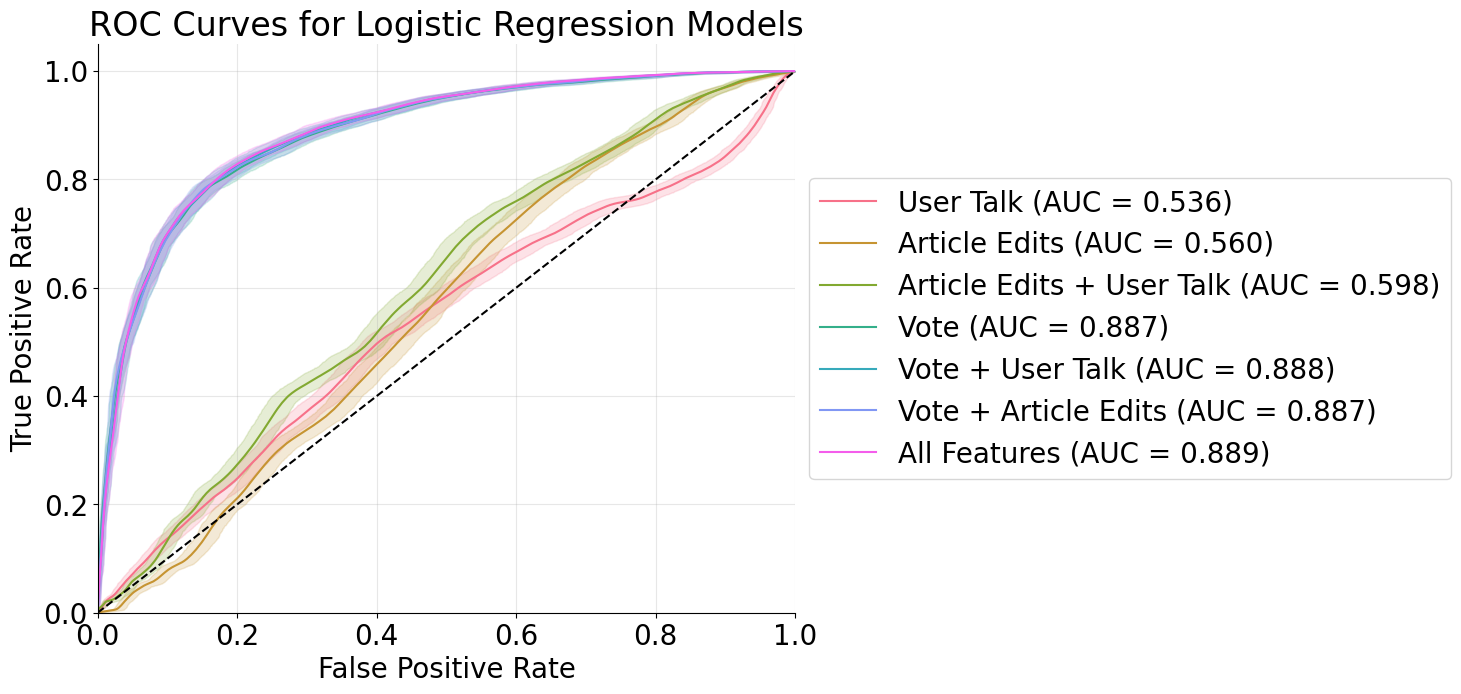

In [72]:
plot_roc_curves(display_modeling, test_datasets, "logistic_regression")

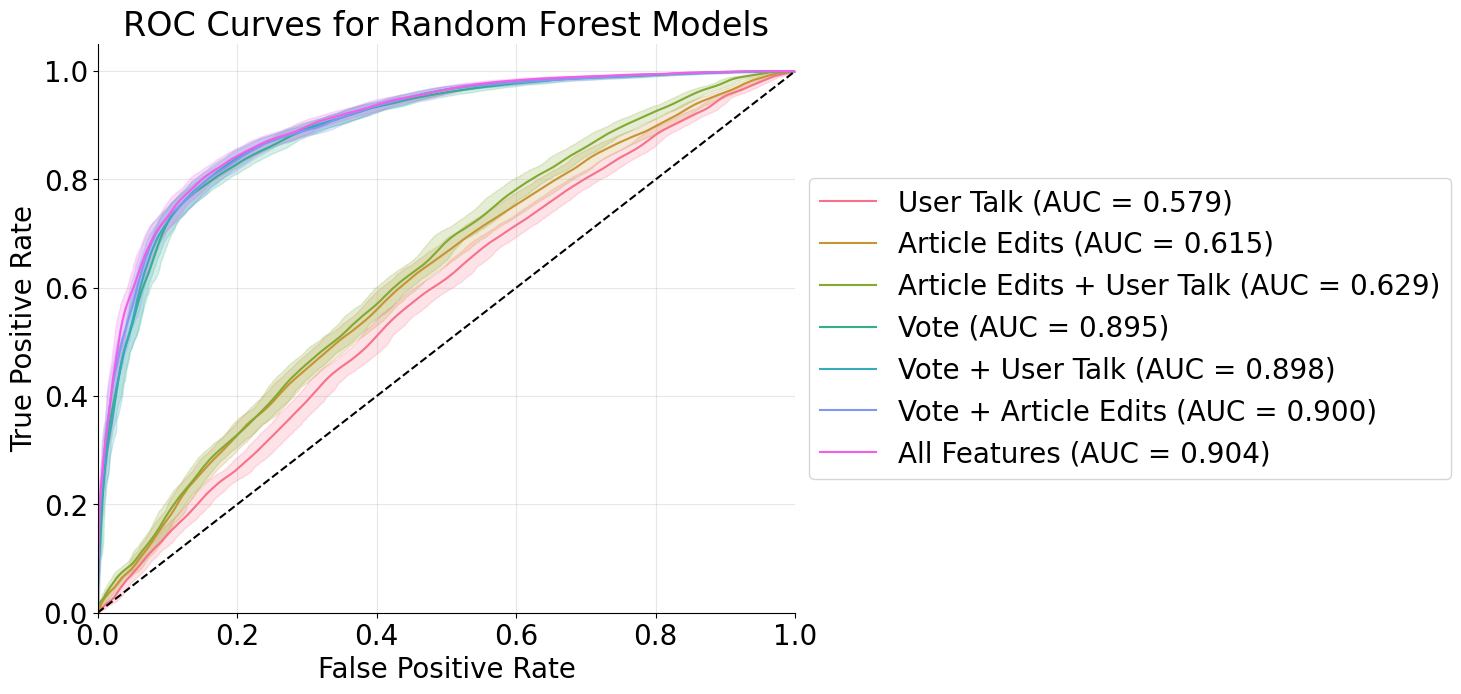

In [73]:
plot_roc_curves(display_modeling, test_datasets, "random_forest")

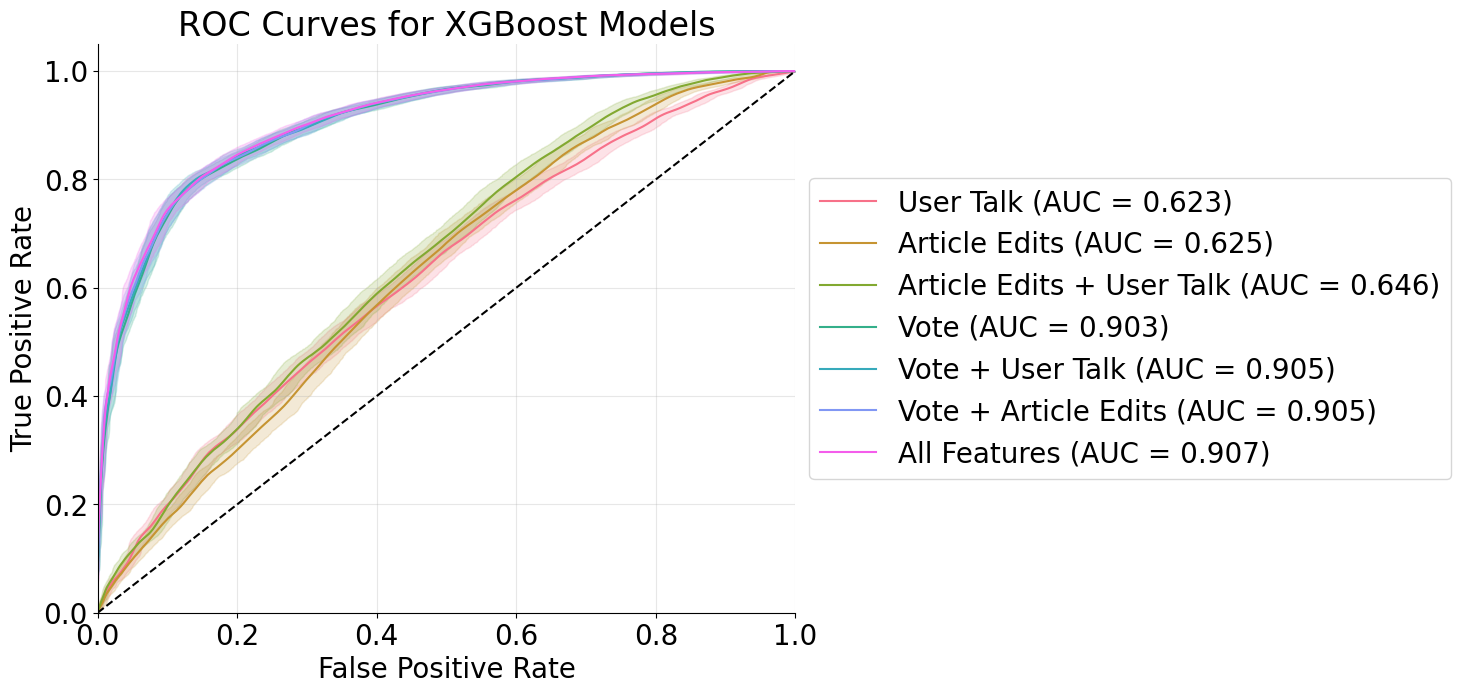

In [74]:
# Plot ROC curves
plot_roc_curves(display_modeling, test_datasets, "xgboost")

### Pairwise DeLong test

In [51]:
# Create comparison table
results = []

for model_type in display_modeling.keys():
    model_pairs = list(itertools.combinations(display_modeling[model_type].keys(), 2))
    seen_pairs = set()  # Keep track of model pairs already compared
    
    for model1_name, model2_name in model_pairs:
        # Skip if we've already seen this pair
        pair_key = tuple(sorted([model1_name, model2_name]))
        if pair_key in seen_pairs:
            continue
        seen_pairs.add(pair_key)
        
        # Get predictions for both models
        model1 = modeling[model_type][model1_name]
        model2 = modeling[model_type][model2_name]
        
        # Get corresponding test datasets
        X_test1, y_test1 = get_variables(test_datasets[model1_name], "label")
        X_test2, y_test2 = get_variables(test_datasets[model2_name], "label")
        
        # Get predictions
        y_pred1 = model1.predict_proba(X_test1)[:, 1]
        y_pred2 = model2.predict_proba(X_test2)[:, 1]
        
        # Calculate AUC scores
        auc1 = roc_auc_score(y_test1, y_pred1)
        auc2 = roc_auc_score(y_test2, y_pred2)
        
        # Perform DeLong test using MLstatkit
        z_score, p_value = Delong_test(y_test1, y_pred1, y_pred2)
        
        # Add to results
        results.append({
            'Model Type': model_names.get(model_type, model_type),
            'Model 1': name_mapping.get(model1_name, model1_name),
            'Model 2': name_mapping.get(model2_name, model2_name),
            'AUC 1': f"{auc1:.4f}",
            'AUC 2': f"{auc2:.4f}",
            "AUC Difference": f"{auc1 - auc2:.4f}",
            'z-score': f"{z_score:.4f}",
            'p-value': f"{p_value:.4f}",
            'Significant': p_value < 0.05
        })

# Create DataFrame and sort by Model Type and p-value
results_df = pd.DataFrame(results).sort_values(['Model Type', 'p-value'])

# Display results
print("\nDeLong Test Results:")
display(results_df)



DeLong Test Results:


,Model Type,Model 1,Model 2,AUC 1,AUC 2,AUC Difference,z-score,p-value,Significant
1,Logistic Regression,User Talk,Article Edits + User Talk,0.5364,0.5984,-0.0620,-6.7538,0.0000,True
2,Logistic Regression,User Talk,Vote,0.5364,0.8867,-0.3502,-44.9076,0.0000,True
3,Logistic Regression,User Talk,Vote + User Talk,0.5364,0.8880,-0.3515,-43.2448,0.0000,True
4,Logistic Regression,User Talk,Vote + Article Edits,0.5364,0.8874,-0.3510,-44.7225,0.0000,True
5,Logistic Regression,User Talk,All Features,0.5364,0.8887,-0.3523,-43.2141,0.0000,True
...,...,...,...,...,...,...,...,...,...
43,XGBoost,User Talk,Article Edits + User Talk,0.6234,0.6460,-0.0226,-2.9135,0.0036,True
62,XGBoost,Vote + Article Edits,All Features,0.9051,0.9068,-0.0017,-2.7979,0.0051,True
57,XGBoost,Vote,Vote + User Talk,0.9032,0.9047,-0.0015,-2.3003,0.0214,True
60,XGBoost,Vote + User Talk,Vote + Article Edits,0.9047,0.9051,-0.0004,-0.5628,0.5735,False


In [52]:
baseline_models = {
    'logistic_regression': modeling['logistic_regression']['baseline_model'],
    'random_forest': modeling['random_forest']['baseline_model'],
    'xgboost': modeling['xgboost']['baseline_model']
}

# Get predictions for baseline models
X_test, y_test = get_variables(base_test, "label")
predictions = {}

for name, model in baseline_models.items():
    predictions[name] = model.predict_proba(X_test)[:, 1]

# Perform pairwise DeLong tests
model_pairs = [
    ('logistic_regression', 'random_forest'),
    ('logistic_regression', 'xgboost'),
    ('random_forest', 'xgboost')
]

results = []
for model1_name, model2_name in model_pairs:
    # Get predictions
    y_pred1 = predictions[model1_name]
    y_pred2 = predictions[model2_name]
    
    # Calculate AUC scores
    auc1 = roc_auc_score(y_test, y_pred1)
    auc2 = roc_auc_score(y_test, y_pred2)
    
    # Perform DeLong test
    z_score, p_value = Delong_test(y_test, y_pred1, y_pred2)
    
    results.append({
        'Model 1': model1_name,
        'Model 2': model2_name,
        'AUC 1': f"{auc1:.4f}",
        'AUC 2': f"{auc2:.4f}",
        'AUC Difference': f"{auc1 - auc2:.4f}",
        'z-score': f"{z_score:.4f}",
        'p-value': f"{p_value:.4f}",
        'Significant': p_value < 0.05
    })

# Create and display results DataFrame
results_df = pd.DataFrame(results)
print("\nDeLong Test Results for Baseline Models:")
display(results_df)


DeLong Test Results for Baseline Models:


,Model 1,Model 2,AUC 1,AUC 2,AUC Difference,z-score,p-value,Significant
0,logistic_regression,random_forest,0.8867,0.8946,-0.0080,-3.9357,0.0001,True
1,logistic_regression,xgboost,0.8867,0.9032,-0.0165,-10.8671,0.0000,True
2,random_forest,xgboost,0.8946,0.9032,-0.0086,-6.1468,0.0000,True
